In [1]:
import psycopg2
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import scipy
import utils

#import warnings
#warnings.filterwarnings("ignore")

# a) Realizar o “restore” do arquivo (dump) denominado fd_whatsapp_0911_2023.zip 
no PostgreSQ.  Esse arquivo está disponível no link a seguir:

In [2]:
# usei o comando: psql -U postgres -d lista2 -f fd_whatsapp_0911_2023.dump


In [3]:
dict_connect = {
    "dbname" : "lista4",
    "user" : "postgres",
    "password": "123321",
    "host": "localhost"
}
conn = psycopg2.connect(**dict_connect)
df = pd.read_sql('SELECT * FROM tb_whatsapp_messages', con=conn)
df.info()

C:\Users\Pichau\AppData\Local\Temp\ipykernel_3720\255694495.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('SELECT * FROM tb_whatsapp_messages', con=conn)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407957 entries, 0 to 407956
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      407957 non-null  int64         
 1   date_message            407957 non-null  datetime64[ns]
 2   id_member_anonymous     407957 non-null  object        
 3   ddi                     407957 non-null  object        
 4   ddd                     406311 non-null  object        
 5   country                 407866 non-null  object        
 6   country_iso3            407866 non-null  object        
 7   state                   406311 non-null  object        
 8   id_group_anonymous      407957 non-null  object        
 9   media                   185568 non-null  object        
 10  media_type              187528 non-null  object        
 11  media_url               132949 non-null  object        
 12  has_media               407957

# b) Remova os trava-zaps.

In [4]:
print("Quantidade de trava_zaps = {}".format(df["trava_zap"].sum()))
df = df[ df["trava_zap"] == False ]
print("Quantidade de trava_zaps = {}".format(df["trava_zap"].sum()))

Quantidade de trava_zaps = 46
Quantidade de trava_zaps = 0


# c) Remover as linhas repetidas (duplicadas).

In [5]:
print("Quantidade de linhas duplicadas = {}".format(df.duplicated().sum()))
df = df[ ~df.duplicated() ]
print("Quantidade de linhas duplicadas = {}".format(df.duplicated().sum()))


Quantidade de linhas duplicadas = 0
Quantidade de linhas duplicadas = 0


# d) Remover textos com menos de 5 palavras.

In [6]:
def menos_de_5_palavras(x):
    if type(x) != str:
        return True
    elif len(x.split()) < 5:
        return True
    return False
    
menos_de_5p = df["text_content_anonymous"].apply(menos_de_5_palavras)
print("Quantidade de textos com menos de 5 palavras = {}".format(menos_de_5p.sum()))
df = df[ ~menos_de_5p ]
print("Quantidade de textos com menos de 5 palavras = {}".format(df["text_content_anonymous"].apply(menos_de_5_palavras).sum()))

Quantidade de textos com menos de 5 palavras = 222456
Quantidade de textos com menos de 5 palavras = 0


# e) Para cada atributo numérico apresente:

In [7]:
df["latitude"] = df.latitude.astype(float)
df["longitude"] = df.longitude.astype(float)

In [8]:
atributos_numericos = df.select_dtypes(include = [int, float])
atributos_numericos.columns

Index(['id', 'latitude', 'longitude', 'score_sentiment',
       'score_misinformation'],
      dtype='object')

## 1. Medidas de Tendência Central

### Média

In [9]:
atributos_numericos.mean()

id                      3.392444e+06
latitude               -1.224632e+01
longitude              -4.654177e+01
score_sentiment        -8.392141e-02
score_misinformation    3.046112e-01
dtype: float64

### Mediana

In [10]:
atributos_numericos.median()

id                      3.395549e+06
latitude               -1.088551e+01
longitude              -4.415887e+01
score_sentiment         0.000000e+00
score_misinformation    1.879243e-01
dtype: float64

### Moda

In [11]:
atributos_numericos.mode()

,id,latitude,longitude,score_sentiment,score_misinformation
0,3187810,-23.550651,-46.633382,0.0,0.014752
1,3187811,NaN,NaN,NaN,NaN
2,3187812,NaN,NaN,NaN,NaN
3,3187813,NaN,NaN,NaN,NaN
4,3187815,NaN,NaN,NaN,NaN
...,...,...,...,...,...
185450,3595782,NaN,NaN,NaN,NaN
185451,3595785,NaN,NaN,NaN,NaN
185452,3595786,NaN,NaN,NaN,NaN
185453,3595787,NaN,NaN,NaN,NaN


## 2. Medidas de Variabilidade

### Variância e Desvio Padrão

In [12]:
atributos_numericos.agg(["var", "std"]).T

,var,std
id,1.363981e+10,116789.611436
latitude,1.091526e+02,10.447612
longitude,1.449861e+02,12.041018
score_sentiment,2.220093e-01,0.471179
score_misinformation,9.156995e-02,0.302605


### Min, Max, Amplitude

In [13]:
variabilidade = atributos_numericos.agg(["min", "max"]).T
variabilidade["amplitude"] = variabilidade["max"] - variabilidade["min"]
variabilidade

,min,max,amplitude
id,3.187810e+06,3.595788e+06,407978.000000
latitude,-3.499650e+01,5.108342e+01,86.079916
longitude,-1.004459e+02,1.392394e+02,239.685300
score_sentiment,-9.998000e-01,9.997000e-01,1.999500
score_misinformation,2.489067e-06,1.000000e+00,0.999998


### 25%, 75%, IQR

In [14]:
quartis = atributos_numericos.describe().T[["25%", "75%"]]
quartis["IQR"] = quartis["75%"] - quartis["25%"]
quartis

,25%,75%,IQR
id,3.291518e+06,3.490734e+06,199215.000000
latitude,-2.291101e+01,-5.326470e+00,17.584543
longitude,-5.013929e+01,-3.971561e+01,10.423685
score_sentiment,-4.466000e-01,2.003000e-01,0.646900
score_misinformation,5.539010e-02,4.906211e-01,0.435231


## 3. Tabela de Frequência e Histograma

### Histogramas

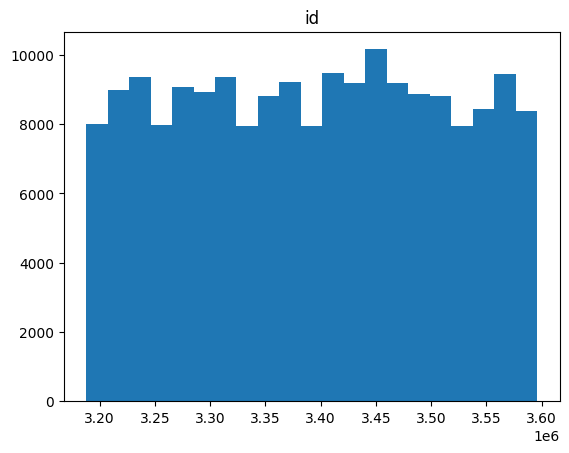

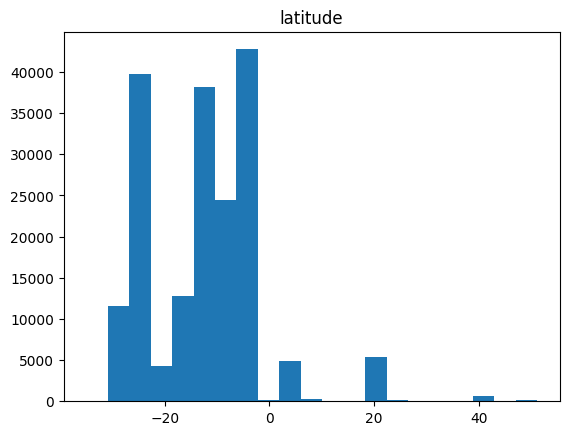

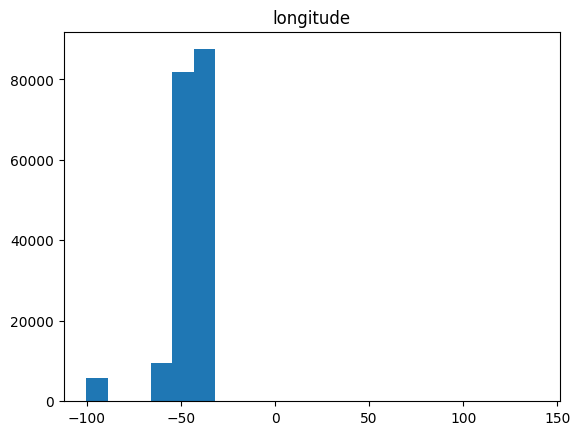

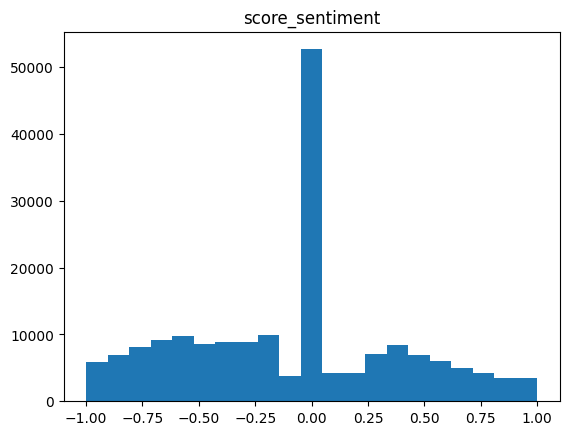

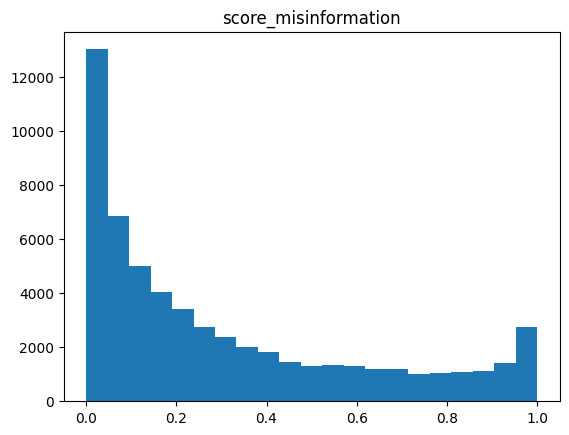

In [15]:
for col in atributos_numericos.columns:
    k = math.ceil(1 + 3.3 * math.log10( atributos_numericos.size ))
    plt.hist(atributos_numericos[col], bins=k)
    plt.title(col)
    plt.show()


### Tabela de Frequencias

In [16]:
for col in atributos_numericos.columns:
    n = atributos_numericos[col].count()
    bins = 10
    amplitude = atributos_numericos[col].max() - atributos_numericos[col].min()
    frequencias = pd.cut(atributos_numericos[col].dropna(), bins = bins).value_counts().sort_index()
    tabela = pd.DataFrame([frequencias, frequencias / n], index = ["Frequencia", "Freq Rel"]).T
    tabela["Freq Perc"] = tabela["Freq Rel"] * 100
    tabela["Freq Acum"] = tabela["Freq Perc"].expanding().sum()
    tabela["Densidade"] = tabela["Frequencia"] / (n * amplitude / bins)
    print(tabela)
    print()

                          Frequencia  Freq Rel  Freq Perc   Freq Acum  \
id                                                                      
(3187402.022, 3228607.8]     18018.0  0.097156   9.715564    9.715564   
(3228607.8, 3269405.6]       18127.0  0.097743   9.774339   19.489903   
(3269405.6, 3310203.4]       19007.0  0.102488  10.248847   29.738751   
(3310203.4, 3351001.2]       17763.0  0.095781   9.578065   39.316815   
(3351001.2, 3391799.0]       18352.0  0.098957   9.895662   49.212477   
(3391799.0, 3432596.8]       19040.0  0.102666  10.266642   59.479119   
(3432596.8, 3473394.6]       20759.0  0.111936  11.193551   70.672670   
(3473394.6, 3514192.4]       18410.0  0.099269   9.926936   80.599606   
(3514192.4, 3554990.2]       17372.0  0.093672   9.367232   89.966838   
(3554990.2, 3595788.0]       18607.0  0.100332  10.033162  100.000000   

                          Densidade  
id                                   
(3187402.022, 3228607.8]   0.000002  
(3228607.

## 4. Boxplot

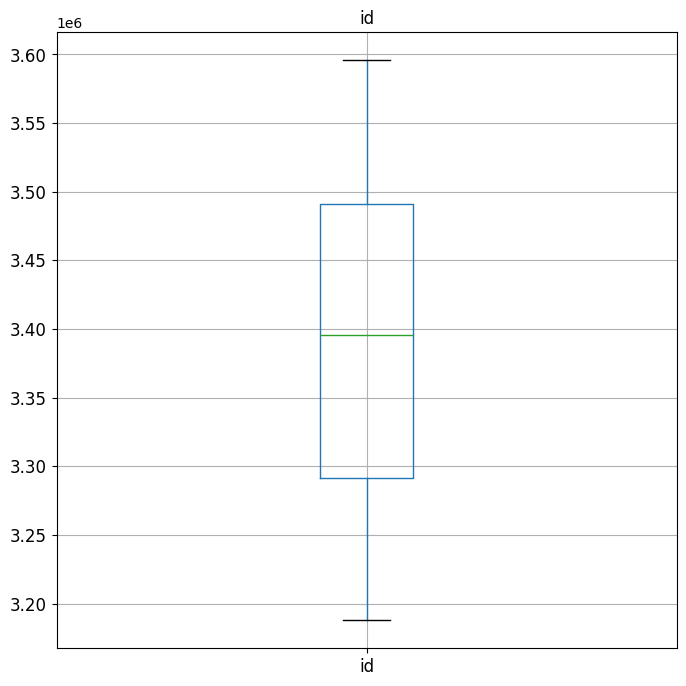

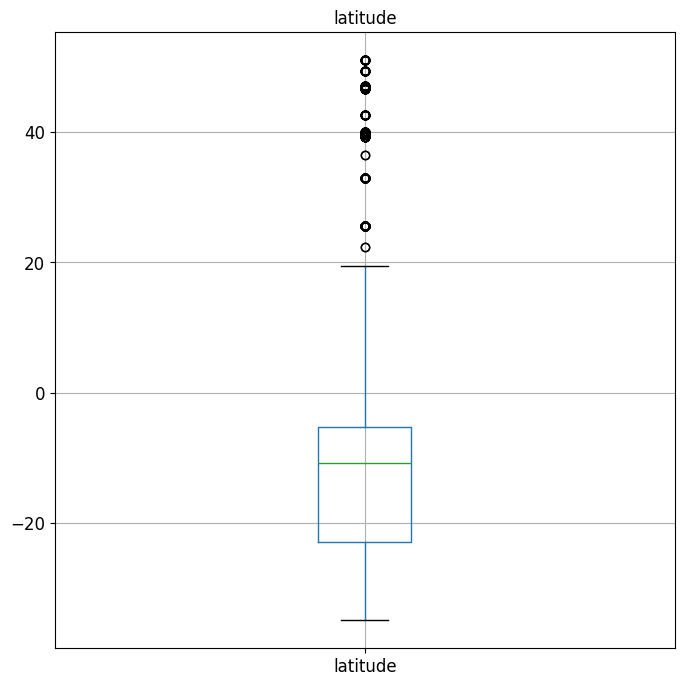

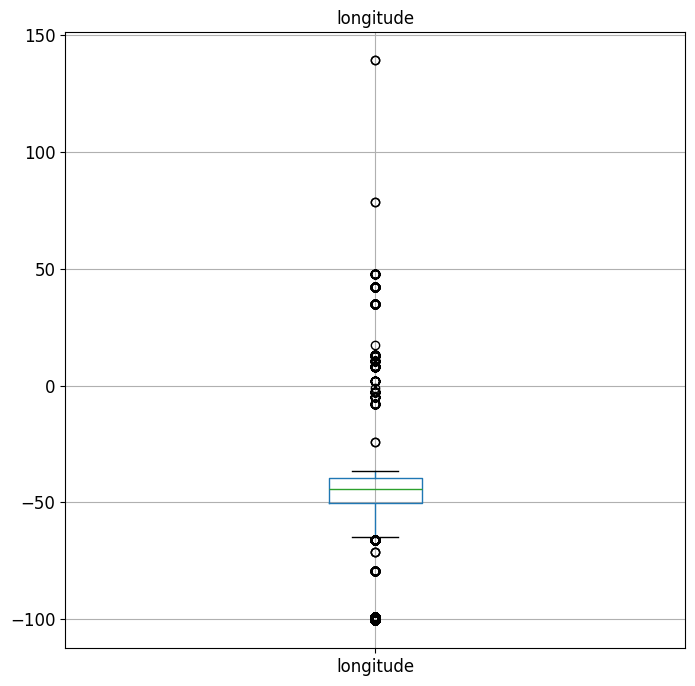

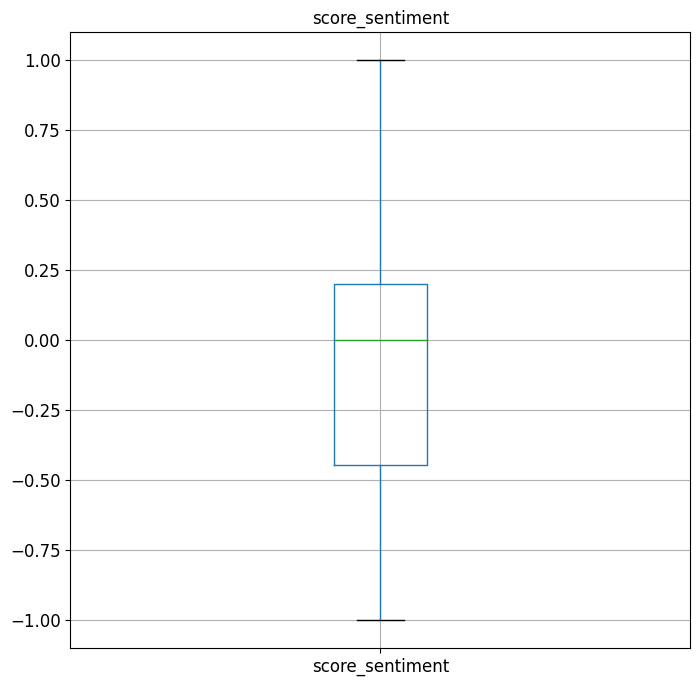

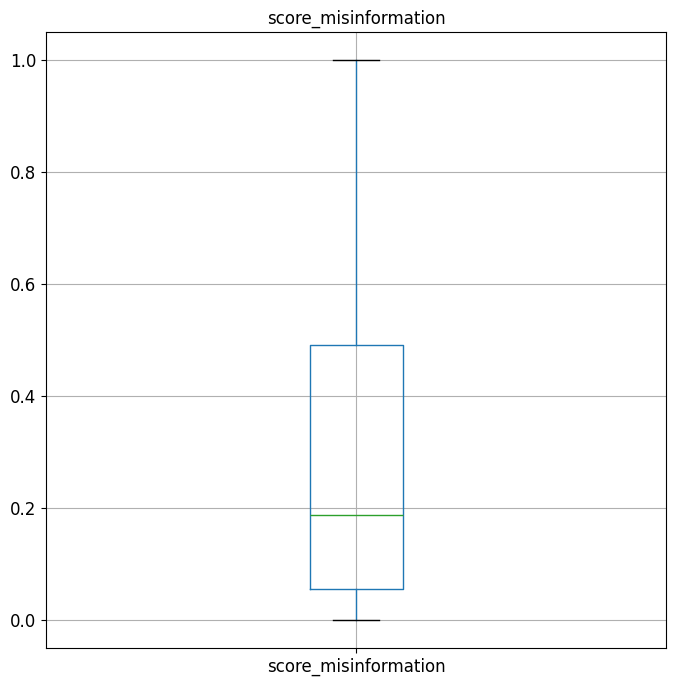

In [17]:
for col in atributos_numericos.columns:
    atributos_numericos.boxplot(column=col, fontsize='large', figsize=(8,8))
    plt.title(col)
    plt.show()

## 5. QQ-Plot

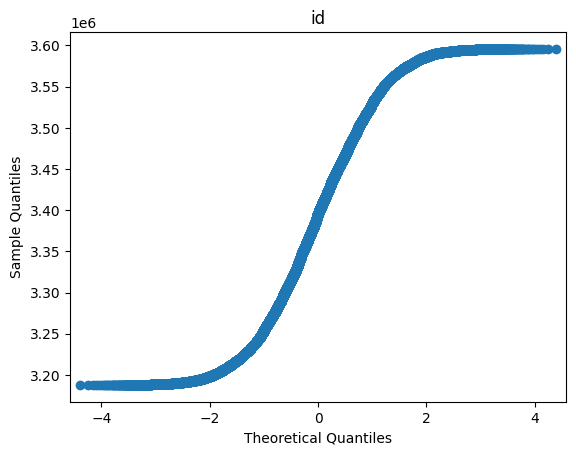

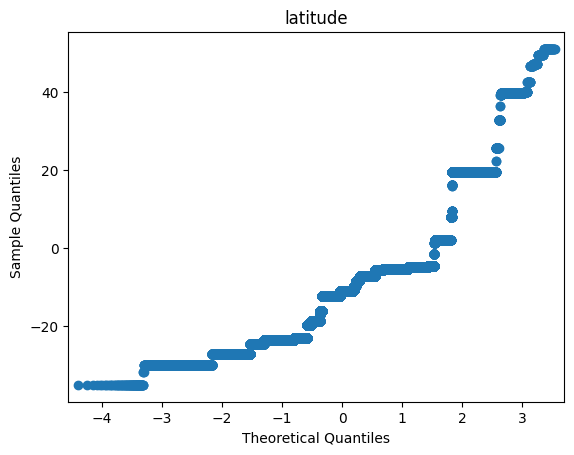

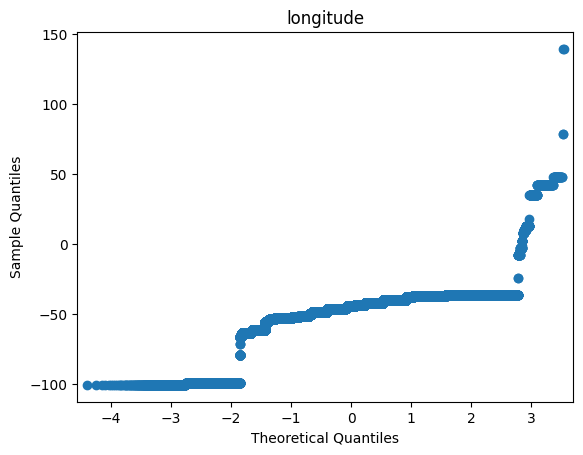

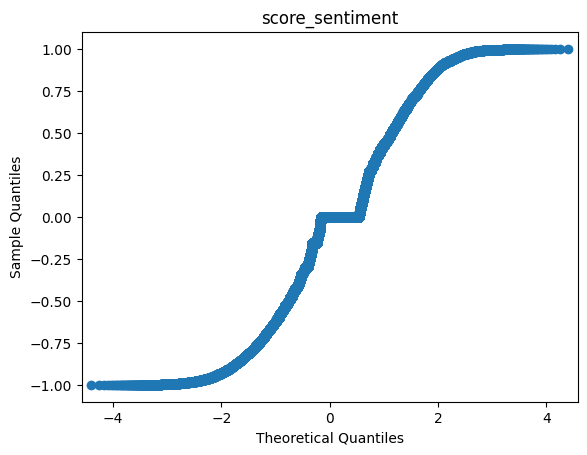

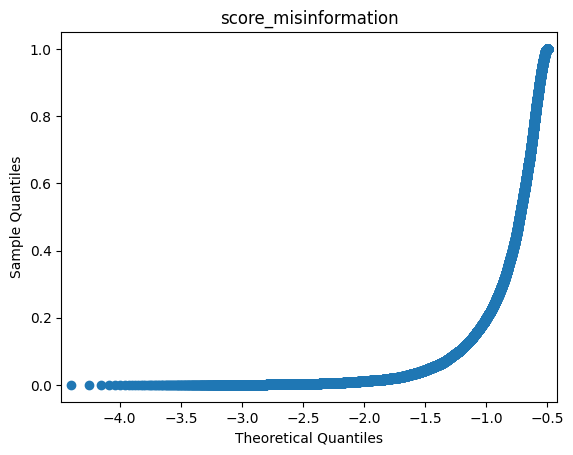

In [18]:
for col in atributos_numericos.columns:
    sm.qqplot(atributos_numericos[col]) 
    plt.title(col)
    plt.show()

## 6. Teste de Normalidade

In [19]:
for col in atributos_numericos.columns:
    print(col)
    utils.check_normality(atributos_numericos[col])
    print()

id


C:\Users\Pichau\Documents\Semestre7\Mineracao de Dados\Lista4\utils.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.03987299601766309' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  table_df.iloc[i, table_df.columns.get_loc("D_pos")] = table_df['FracEsp'].iloc[i]


Os dados não seguem uma distribuição normal.

latitude
Os dados não seguem uma distribuição normal.

longitude


C:\Users\Pichau\Documents\Semestre7\Mineracao de Dados\Lista4\utils.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.13962588088240846' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  table_df.iloc[i, table_df.columns.get_loc("D_pos")] = table_df['FracEsp'].iloc[i]
C:\Users\Pichau\Documents\Semestre7\Mineracao de Dados\Lista4\utils.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.49696480649467684' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  table_df.iloc[i, table_df.columns.get_loc("D_pos")] = table_df['FracEsp'].iloc[i]


Os dados não seguem uma distribuição normal.

score_sentiment


C:\Users\Pichau\Documents\Semestre7\Mineracao de Dados\Lista4\utils.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5706815163849843' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  table_df.iloc[i, table_df.columns.get_loc("D_pos")] = table_df['FracEsp'].iloc[i]


Os dados não seguem uma distribuição normal.

score_misinformation


C:\Users\Pichau\Documents\Semestre7\Mineracao de Dados\Lista4\utils.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.169061561561814' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  table_df.iloc[i, table_df.columns.get_loc("D_pos")] = table_df['FracEsp'].iloc[i]


Os dados não seguem uma distribuição normal.



## 7. Best Fit


In [20]:
dist_names = ['beta',
              'expon',
              'gamma',
              'lognorm',
              'norm',
              'pearson3',
              't',
              'triang',
              'uniform',
              'weibull_min', 
              'weibull_max']

In [21]:
for col in atributos_numericos.columns:
    print("Coluna:", col)
    y_std  = scipy.stats.zscore(atributos_numericos[col].dropna())
    utils.check_distribution(dist_names, y_std)
    print()

Coluna: id


C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:6111: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)



Distributions sorted by goodness of fit:
----------------------------------------
   Distribution  Distance       p_value D<p
0          beta  0.008044  7.524266e-11  no
8       uniform  0.009620  2.454994e-15  no
1         expon  0.158703  0.000000e+00  no
2         gamma  0.056710  0.000000e+00  no
3       lognorm  0.056112  0.000000e+00  no
4          norm  0.056965  0.000000e+00  no
5      pearson3  0.058907  0.000000e+00  no
6             t  0.056965  0.000000e+00  no
7        triang  0.126065  0.000000e+00  no
9   weibull_min  0.061328  0.000000e+00  no
10  weibull_max  0.065697  0.000000e+00  no

Coluna: latitude


C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:6111: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)



Distributions sorted by goodness of fit:
----------------------------------------
   Distribution  Distance  p_value D<p
0          beta  0.185646      0.0  no
1         expon  0.307151      0.0  no
2         gamma  0.185640      0.0  no
3       lognorm  0.184538      0.0  no
4          norm  0.166123      0.0  no
5      pearson3  0.185639      0.0  no
6             t  0.147072      0.0  no
7        triang  0.417858      0.0  no
8       uniform  0.582979      0.0  no
9   weibull_min  0.199968      0.0  no
10  weibull_max  0.185646      0.0  no

Coluna: longitude


C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:6111: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)



Distributions sorted by goodness of fit:
----------------------------------------
   Distribution  Distance  p_value D<p
0          beta  0.195547      0.0  no
1         expon  0.490541      0.0  no
2         gamma  0.215466      0.0  no
3       lognorm  0.197689      0.0  no
4          norm  0.199127      0.0  no
5      pearson3  0.194638      0.0  no
6             t  0.129354      0.0  no
7        triang  0.582213      0.0  no
8       uniform  0.730605      0.0  no
9   weibull_min  0.244094      0.0  no
10  weibull_max  0.312075      0.0  no

Coluna: score_sentiment


C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:6111: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)



Distributions sorted by goodness of fit:
----------------------------------------
   Distribution  Distance  p_value D<p
0          beta  0.136976      0.0  no
1         expon  0.228624      0.0  no
2         gamma  0.146705      0.0  no
3       lognorm  0.146894      0.0  no
4          norm  0.137900      0.0  no
5      pearson3  0.148798      0.0  no
6             t  0.137900      0.0  no
7        triang  0.184402      0.0  no
8       uniform  0.208557      0.0  no
9   weibull_min  0.151714      0.0  no
10  weibull_max  0.141002      0.0  no

Coluna: score_misinformation


C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:6111: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)



Distributions sorted by goodness of fit:
----------------------------------------
   Distribution  Distance        p_value D<p
2         gamma  0.050544  4.188357e-128  no
5      pearson3  0.050763  3.269177e-129  no
9   weibull_min  0.053204  6.677794e-142  no
0          beta  0.091691   0.000000e+00  no
1         expon  0.087259   0.000000e+00  no
3       lognorm  0.083399   0.000000e+00  no
4          norm  0.152282   0.000000e+00  no
6             t  0.157056   0.000000e+00  no
7        triang  0.191267   0.000000e+00  no
8       uniform  0.326320   0.000000e+00  no
10  weibull_max  0.116043   0.000000e+00  no



# f) Para cada par de atributos numéricos apresente:

## 2. Gráfico de dispersão

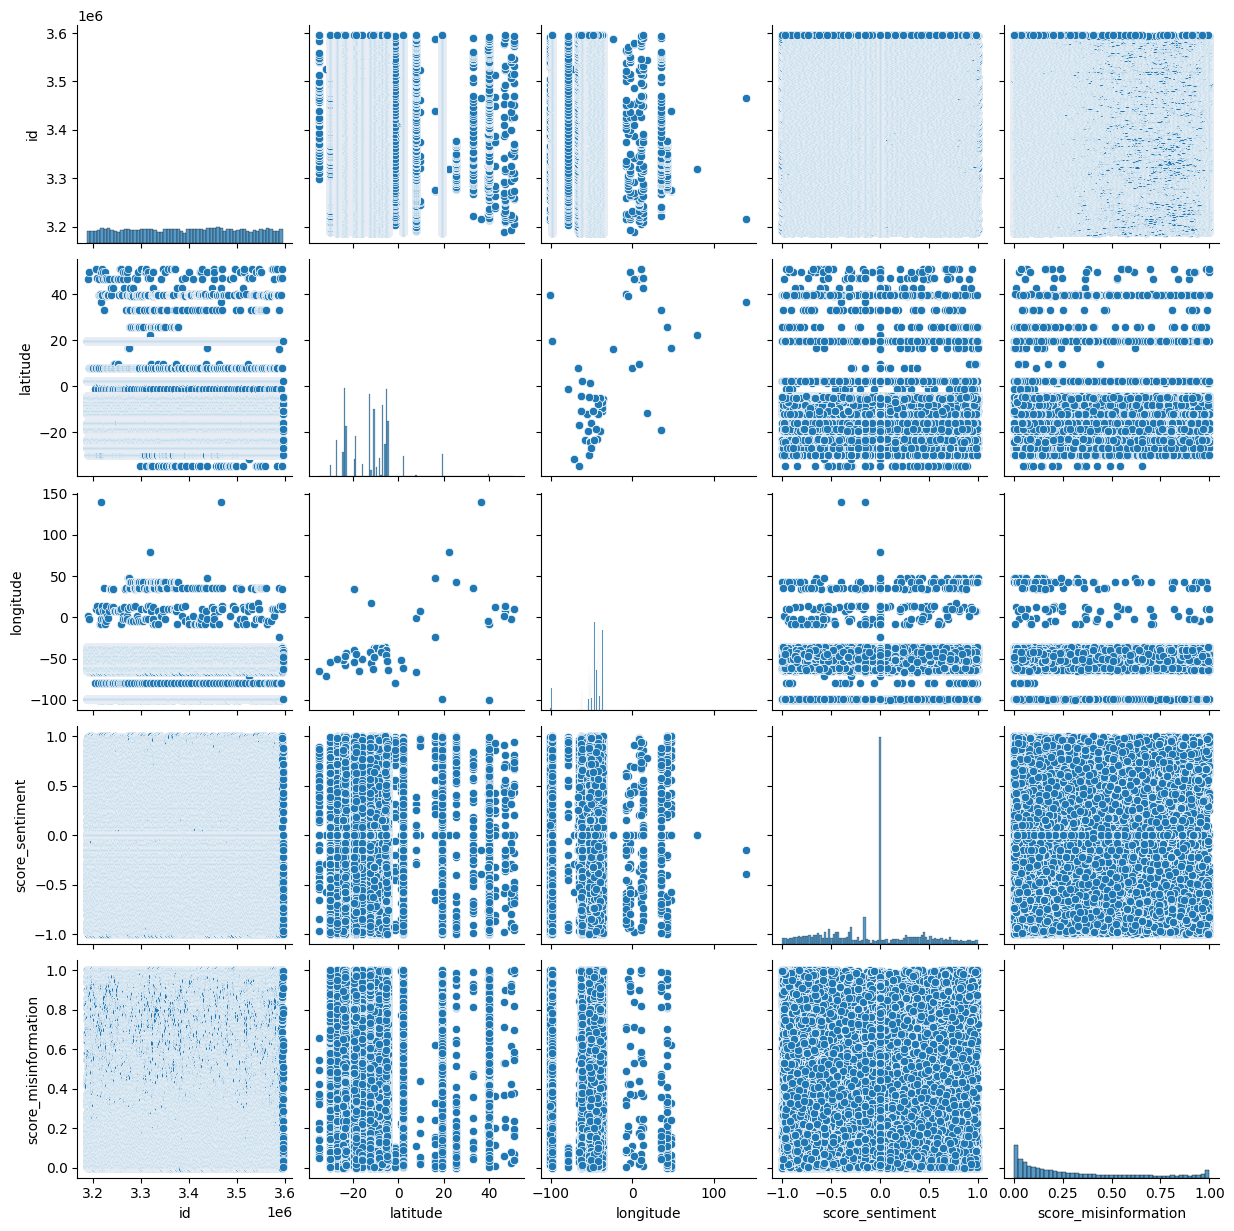

In [22]:
atributos_numericos = df.select_dtypes(include = [int, float])
sns.pairplot(atributos_numericos)


## 1. O Coeficiente de Correlação apropriado

<Axes: >

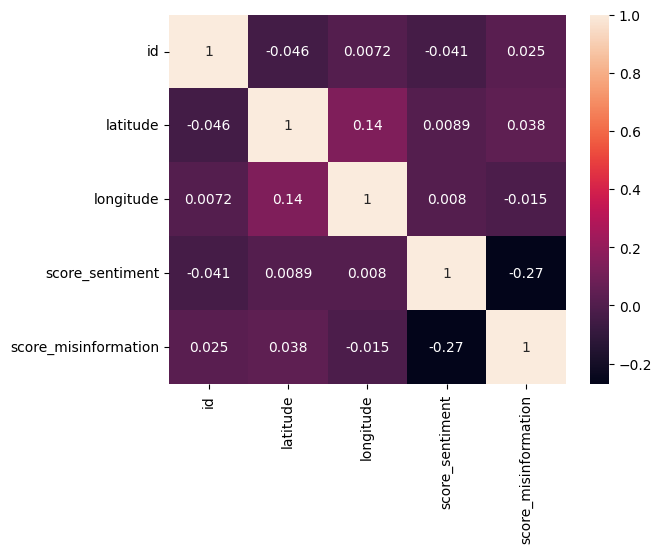

In [23]:
# Como nenhum atributo possui distribuição normal e nenhum par de atributos aparentam ter uma correlação linear, utilizarei Spearman

correlations = atributos_numericos.corr(method = "spearman")
sns.heatmap(correlations, annot = True)

# g) Para cada par de atributos categóricos apresente:

## 1. O resultado do método V de Cramer

In [24]:
atributos_categoricos = df.select_dtypes(include = [object, bool])
atributos_categoricos.columns

cols_filtradas = []
for col in atributos_categoricos.columns:
    if (len(atributos_categoricos[col].unique()) < 2) | (len(atributos_categoricos[col].unique()) > 200):
        continue
    cols_filtradas.append(col)
cols_filtradas

['ddi',
 'ddd',
 'country',
 'country_iso3',
 'state',
 'media_type',
 'has_media',
 'has_media_url',
 'media_name']

In [25]:
def v_de_cramer(atributo1, atributo2):
    df_atributo1 = atributos_categoricos[atributo1].astype(object).fillna("None")
    df_atributo2 = atributos_categoricos[atributo2].astype(object).fillna("None")
    contingency_table = pd.crosstab(df_atributo1, df_atributo2).fillna(0)
    chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)
    
    
    n = contingency_table.sum().sum()  
    min_dim = min(contingency_table.shape) - 1 
    
    V_cramer = np.sqrt(chi2 / (n * min_dim))
    
    return V_cramer

n_cols = len(cols_filtradas)
df_v_cramer = pd.DataFrame(index = cols_filtradas, columns = cols_filtradas)
for i in range(n_cols):
    for j in range(n_cols):
        col1 = cols_filtradas[i]
        col2 = cols_filtradas[j]
        
        df_v_cramer.loc[col1, col2] = v_de_cramer(col1, col2)
df_v_cramer = df_v_cramer.astype(float)

<Axes: >

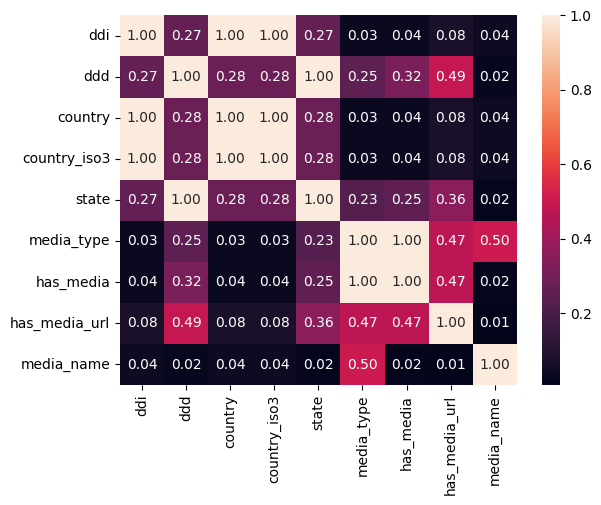

In [26]:
sns.heatmap(df_v_cramer, annot = True, fmt = ".2f")

# h) Crie uma visualização (gráfico) para apresentar:

## 1. As quantidades de grupos, usuários e mensagens;

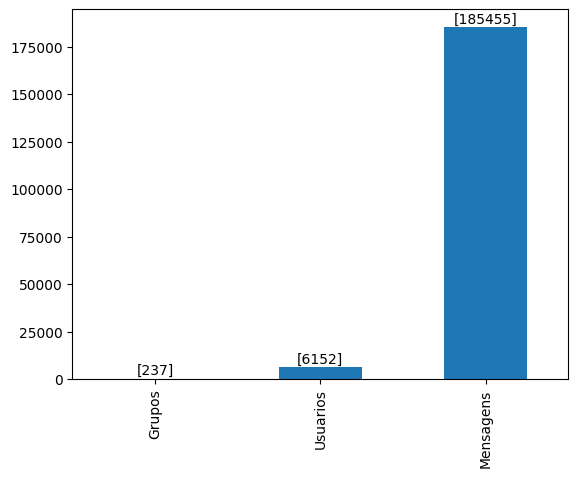

In [27]:
qnt_grupos = len(df["id_group_anonymous"].unique())
qnt_usuarios = len(df["id_member_anonymous"].unique())
qnt_mensagens = len(df)


df_1 = pd.DataFrame([qnt_grupos, qnt_usuarios, qnt_mensagens], index = ["Grupos", "Usuarios", "Mensagens"])
df_1.plot.bar(legend = False)
for i, valor in enumerate(df_1.to_numpy()):
    plt.text(i, valor + 2000, str(valor), ha='center')
plt.show()

## 2. A quantidade de mensagens que possuem apenas texto X mídia;

has_media
False    0.779763
True     0.220237
Name: count, dtype: float64


<Axes: >

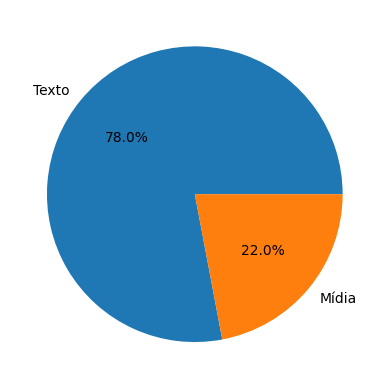

In [28]:
print(df.has_media.value_counts() / df.has_media.count())
df.has_media.value_counts().set_axis(["Texto", "Mídia"]).plot.pie(ylabel = "", autopct='%1.1f%%')

## 3. Quantidade de mensagens por tipo de mídia (jpg, mp4 etc);

<Axes: ylabel='media_type'>

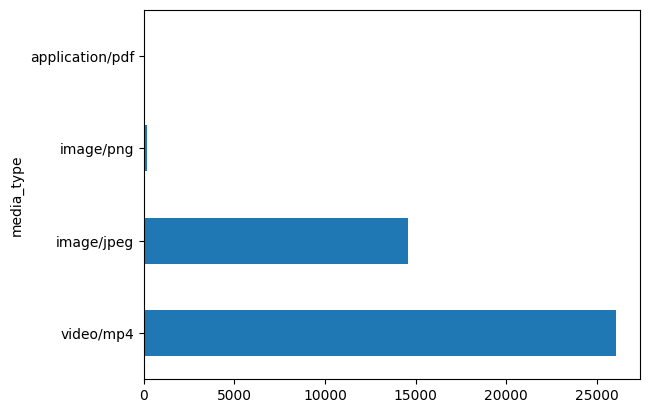

In [29]:
df["media_type"].value_counts().plot.barh()

## 4. A relação entre a quantidade de mensagens e a quantidade de palavras ppresente nas mensagen;

<Axes: xlabel='Quantidade_palavras', ylabel='Count'>

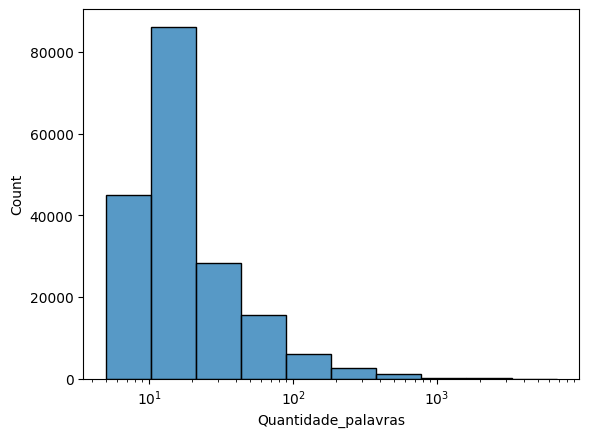

In [30]:
df_4 = df["text_content_anonymous"].apply(lambda x: len(x.split())).rename("Quantidade_palavras")
df_4_count = df_4.value_counts().reset_index().set_axis(["quantidade_palavras", "count"], axis = "columns")
sns.histplot(data=df_4, bins=10, log_scale=True)


## 5. Quantidade de mensagens por estado;

<Axes: xlabel='text_content_anonymous', ylabel='state'>

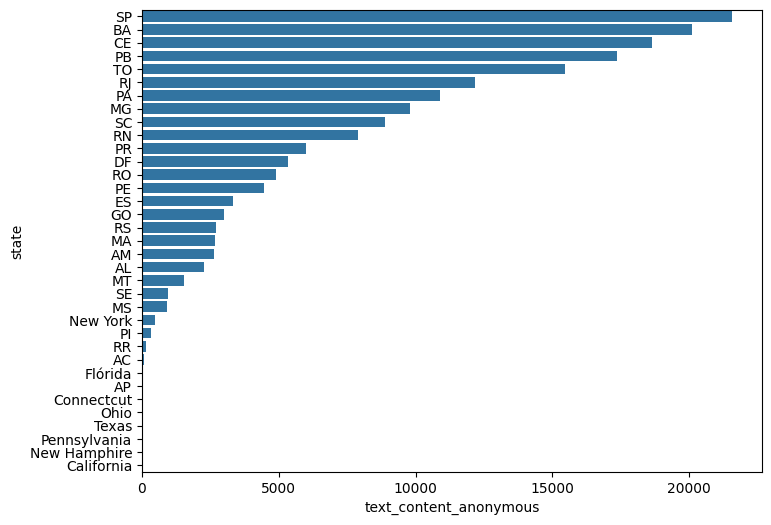

In [31]:
df_5 = df.groupby("state")["text_content_anonymous"].count().reset_index().sort_values(by = "text_content_anonymous", ascending = False)
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(data = df_5, y = "state", x = "text_content_anonymous", ax = ax)


## 6. Quantidade de usuários por estado;

<Axes: xlabel='id_member_anonymous', ylabel='state'>

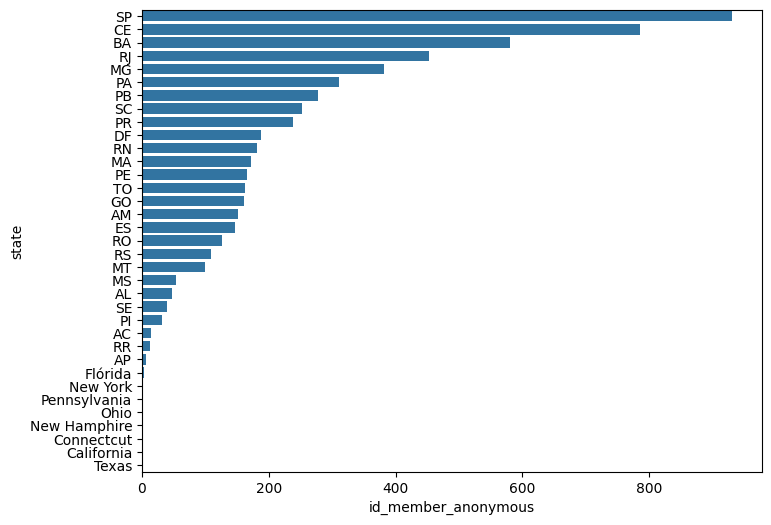

In [32]:
df_6 = df.groupby(["state"])["id_member_anonymous"].nunique().reset_index().sort_values(by = "id_member_anonymous", ascending = False)
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(data = df_6, y = "state", x = "id_member_anonymous", ax = ax)


## 7. Relação quantidade de usuários por quantidade de mensagens por estado;

<Axes: xlabel='relacao', ylabel='state'>

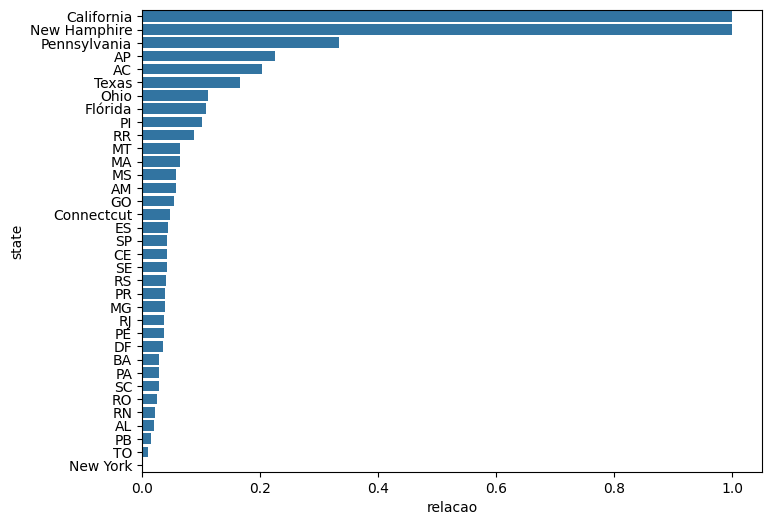

In [33]:
df_7 = df.groupby(["state"])[["id_member_anonymous", "text_content_anonymous"]].agg({
    "id_member_anonymous": lambda x: x.nunique(),
    "text_content_anonymous": "count"
}).reset_index()
df_7["relacao"] = df_7["id_member_anonymous"] / df_7["text_content_anonymous"]
df_7 = df_7.sort_values(by = "relacao", ascending = False)
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(data = df_7, y = "state", x = "relacao", ax = ax)

## 8. Quantidade de mensagens por país;

<Axes: xlabel='text_content_anonymous', ylabel='country'>

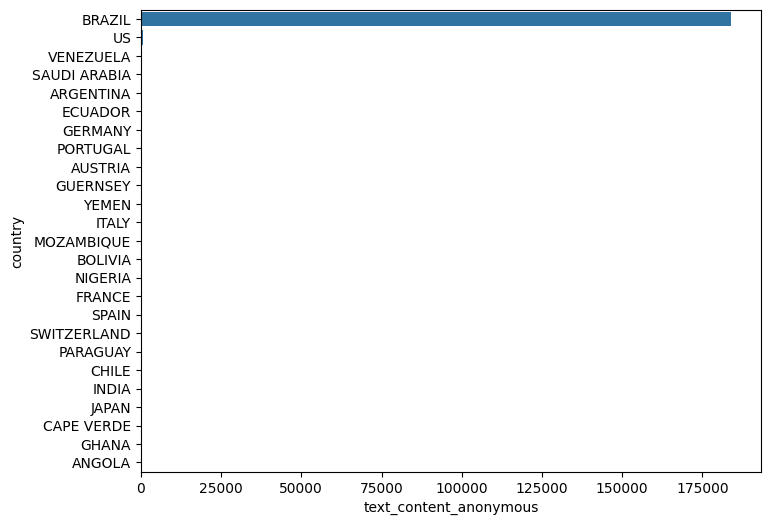

In [34]:
df_8 = df.groupby("country")["text_content_anonymous"].count().reset_index().sort_values(by = "text_content_anonymous", ascending = False)
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(df_8, y = "country", x = "text_content_anonymous", log_scale = False, ax = ax)

## 9. Quantidade de mensagens Brasil X Países Estrangeiros;

<Axes: >

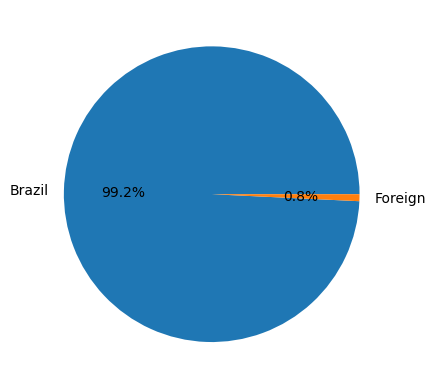

In [35]:
df["country"].apply(lambda x: x == "BRAZIL").value_counts().set_axis(["Brazil", "Foreign"]).plot.pie(ylabel = "", autopct='%1.1f%%')

## 10. As 30 URLs que mais se repetem (mais compartilhadas);

In [36]:
df["media_url"].value_counts().iloc[:30]

media_url
https://gazetabrasil.com.br/assinaturas/                                                                                                         627
https://www.instagram.com/revistarealce/                                                                                                         116
https://www.redebrasilnews.com.br/as-inscricoes-para-o-minha-casa-minha/                                                                          92
portaldeprefeitura.com.br                                                                                                                         89
https://www.enqueteaseleiçoes2023.com                                                                                                             71
https://www.redebrasilnews.com.br/detran-abre-leilao-online/                                                                                      71
https://www.redebrasilnews.com.br/o-bradesco-oferece-um-emprestimo-de-ate/                      

## 11. Os 30 domínios que mais se repetem (mais compartilhados);

<Axes: ylabel='media_url'>

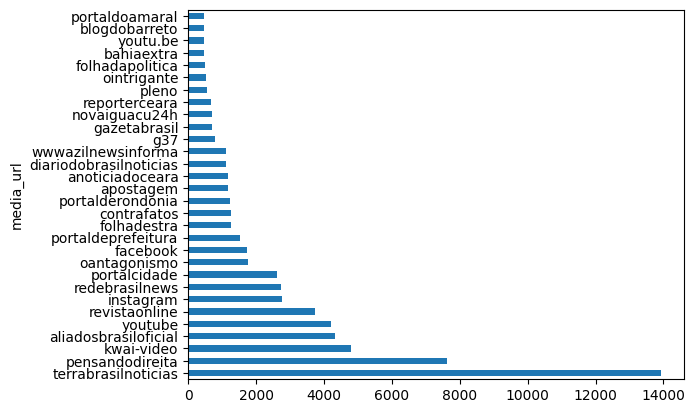

In [37]:
def coleta_dominio(x):
    if type(x) != str:
        return x
    
    try:
        li = x.index("//") + 2
    except:
        li = 0
    
    try:
        ri = x[li:].index("/") + li
    except:
        try: 
            ri = x.index(".com") + li
        except:
            ri = len(x)
            
    return x[li:ri].replace(".com","").replace(".br","").replace("www.","").replace(".news","")
    
df["media_url"].apply(coleta_dominio).value_counts().iloc[:30].plot.barh()

## 12. Os 30 usuários mais ativos;

In [38]:
df["id_member_anonymous"].value_counts().iloc[:30]

id_member_anonymous
ef496106907ece8b169c6219e5470b2c    4660
4ea1b3ee637da811b7d2d0df32db21f9    4405
c5fff63b6151f93e1ce86d12f8acbee1    3259
3545bf472c131392f18ed78a07f7552e    2966
95cbc2a13f1f4996d4510db5aab593b9    2311
fbe74c8d920b0a8c6b79baba03261bec    2043
3d4e77cea17b1812993b55543e81400e    2029
7bc2ca560fc7fb3e7ca04eb78013a58d    2023
386b1828cc8968161a6747fbf815af2b    1907
795c375489bb097fceaccb0c018d3992    1689
d49cc6c9b024321630d3e6d75ab93705    1664
1eb6d457b883d2bec301bb33671e0a86    1654
32886ba63f35b0a7e4c461443549c3e9    1617
37db16871b2131040560a1192fcbc244    1571
ca9f8e50cea929448d2d058aead8ed8c    1536
3bc964535b8e6bae52c2d9b8fcc73024    1428
cc00fce4892b0f78f86556a888376c16    1387
add0bc391a11df3658b54682874bb3e2    1326
5b8098c46723cbaa024fab06bdaad849    1282
275db4424de818eadbe1d4f6bad58f44    1256
ba228d9bb41cb909e669b83bcd01c9d2    1189
c2b374a51f8bc0ff08ba7b1e64b32f88    1175
a5595c3d215d032fe4dd43d236553b92    1149
3d1689a757882397299f68abbb354996    1

## 13. Relação entre quantidade de mensagens contendo somente texto e mensagens com tendo mídia dos usuários mais ativos:

<Axes: >

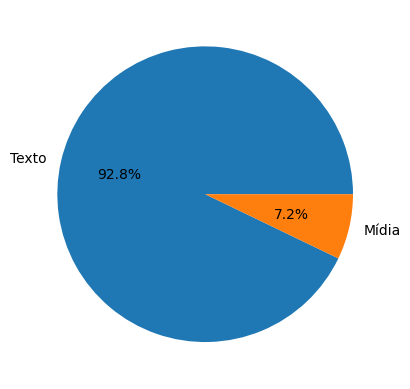

In [39]:
usuarios_mais_ativos= df["id_member_anonymous"].value_counts().iloc[:30].index.values
df_13 = df[df["id_member_anonymous"].isin(usuarios_mais_ativos)]["has_media"].value_counts().set_axis(["Texto", "Mídia"])
df_13.plot.pie(ylabel = "", autopct='%1.1f%%')

## 14. Os 30 usuários que mais compartilharam texto;

In [40]:
df[df["has_media"] == False]["id_member_anonymous"].value_counts().iloc[:30]

id_member_anonymous
ef496106907ece8b169c6219e5470b2c    4660
4ea1b3ee637da811b7d2d0df32db21f9    4405
c5fff63b6151f93e1ce86d12f8acbee1    3259
3545bf472c131392f18ed78a07f7552e    2966
95cbc2a13f1f4996d4510db5aab593b9    2241
fbe74c8d920b0a8c6b79baba03261bec    2043
7bc2ca560fc7fb3e7ca04eb78013a58d    1953
3d4e77cea17b1812993b55543e81400e    1903
386b1828cc8968161a6747fbf815af2b    1725
795c375489bb097fceaccb0c018d3992    1689
1eb6d457b883d2bec301bb33671e0a86    1654
d49cc6c9b024321630d3e6d75ab93705    1635
32886ba63f35b0a7e4c461443549c3e9    1617
37db16871b2131040560a1192fcbc244    1571
3bc964535b8e6bae52c2d9b8fcc73024    1428
5b8098c46723cbaa024fab06bdaad849    1282
cc00fce4892b0f78f86556a888376c16    1281
add0bc391a11df3658b54682874bb3e2    1281
275db4424de818eadbe1d4f6bad58f44    1256
a5595c3d215d032fe4dd43d236553b92    1149
3d1689a757882397299f68abbb354996    1119
d215ebf63f9c5b9dc0bb3922cce20ac8    1107
00755bcec5e1c42fe2ed5754056d503d     852
4b44334cc5e4c42d35213f08916bdcab     

## 15. Os 30 usuários que mais compartilharam mídias;

In [41]:
df[df["has_media"] == True]["id_member_anonymous"].value_counts().iloc[:30]

id_member_anonymous
ca9f8e50cea929448d2d058aead8ed8c    1536
1418b529e5ff3989731c564773316153     648
cafc15b577f7cb76222dd432ee25829e     577
3bd690be70eb0c1bea18aa9b62b7c806     566
85ae0091c4ef0e05ea2fae14f2f03f58     553
ef10411d744f4f56fbb9e9b18ec2799c     510
c369f0bfab115c81038b39f5e3bd790d     509
27e79a36c6ac8ec5a6144cfdc57f20bf     503
c93dfbaf3a8f551b90640950e41a4dc9     489
4e1de25866533497f3ce182382fd5da3     436
473d590d54dc2e540c6b0f03b91d0b4d     404
ba228d9bb41cb909e669b83bcd01c9d2     394
c2b374a51f8bc0ff08ba7b1e64b32f88     370
bd4a0a308029562cde0dbf68484f223e     349
b632aa10c44879310730bbfced256e20     312
e29a9cfc0e233a1a305d1fd9f77d57e2     299
25a66d7bda7171e617448aeb17a46f4b     274
4a9189a9abfd59c27ecc0449263ed02c     263
a09786bffe84a22279feb923a52c17f3     236
9d32bde658339d2e2b957f1e666be1a4     233
0491b0c14be8cab572cc458ce7c8630c     209
1f062a784173f6f9b4692c192a091e9d     202
a5c2cf46f9eea5cf341600fb7f947f3f     199
0916dc69e493d0bfbf6922878553a53d     

## 16. As 30 mensagens mais compartilhadas;

In [42]:
df["text_content_anonymous"].value_counts().iloc[:30].index.values

array(['*Qual  Dessas é  a Sua Religião?*\n\nhttps://youtu.be/5_yg4O1i9hE',
       '*MISERICÓRDIA,  MEU DEUS 😱*\n\nhttps://youtube.com/shorts/64biIpleHsQ?feature=share',
       'LEMBRETE IMPORTANTE: NÃO ESQUEÇA DE LÊ A PALAVRA DO SENHOR.📖',
       'instagram BR 🛍️👨\u200d💻🌎\n\n*100%CONFIAVEL ✅🔰*\n\n🚀ENTREGA RAPIDA🚀\n\nFUNCIONAMENTO 👇🏾\n\n08:00 ATE 22H:00 🔓🏪🛍️\n\n*SOMOS MAIS DE MIL VENDA ON LINE*✅\nTEMOS    👇🏿\n👉🏿LIKES E SEGUIDORES 👈🏿\n            visualização\n                  👆🏿\n*SO EU TENHO ESSA PROMOÇÃO*\n\nPROMOÇÃO DA SEMANA!!!\n\n✅🤑🛍@\nReposição 364 dias\n\n*100 seguidores 1,00R$*🥶🔥\n*200 seguidores 2,00R$*🥶🔥\n*300 seguidores 2,99R$*🥶🔥\n*400 seguidores 3,99R$*🥶🔥\n*500 seguidores 4,99R$*🥶🔥\n*600 seguidores 5,99R$*🥶🔥\n*700 seguidores 6,99R$*🥶🔥\n*800 seguidores 7,99R$*🥶🔥\n*1.000 seguidores 8,99R$*🥶🔥\n*1.500 seguidores 9,99R$*🥶🔥\n*2.500 seguidores 16,99R$*🥶🔥\n*3.500 seguidores 19,99R$*🥶🔥\n*4.000 seguidores 24,99R$*🥶🔥\n*5.000 seguidores 29,99R$*🥶🔥\n*6.000 seguidores 39,99R$🥶🔥*\n*7.000

## 17. As 30 mensagens mais compartilhadas em grupos diferentes;

In [43]:
df.groupby(["text_content_anonymous"]).id_group_anonymous.nunique().sort_values(ascending = False).iloc[:30].index.values

array(['Deputados entram com pedido de impeachment contra o presidente Luiz Inácio Lula da Silva (PT) e querem saber se o povo\xa0esta\xa0com\xa0eles.\xa0Vote. ⤵\n\nhttps://financas-web.club/enquete/',
       'O face bloqueia não deixa postar.                                    ATENÇÃO: A TV Senado apresentou esse vídeo hoje pela manhã! Logo em seguida, o Congresso e Senado ligaram para a própria TV Senado intimando-a, sob forte ameaça e pressão, que retirassem de todos os demais telejornais! E já foi retirado até mesmo do YouTube!! Vamos fazer a nossa parte! Repassem sem dó!',
       '"👆👆 *Os COVARDES* não terão coragem de passar pra frente esse vídeo. Se você não for um desses covardes aliado aos melancias e nem cúmplice do SISTEMA, *COMPARTILHE PARA O MUNDO.*\nNão o conheço pessoalmente.....mas, JA É UM DOS MEUS HERÓIS...."',
       'VAMOS FAZER ESTE VIDEO CIRCULAR POR TODOS AS REDES SOCIAIS DO BRASIL',
       'Se vc é a favor dessa campanha, tire 30 segundos do seu tempo e comparti

## 18. Mensagens idênticas compartilhadas pelo mesmo usuário (e suas qquantidades);

In [44]:
# não entendi

## 19. Mensagens idênticas compartilhadas pelo mesmo usuário em grupos ddistintos (e suas quantidades);

In [45]:
# não entendi

## 20. Os 30 unigramas, bigramas e trigramas mais compartilhados (após a remoção dde stop words);

### Unigramas

In [46]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
nltk.download('punkt')
nltk.download('stopwords')
def corrigir_string(x):
    palavras = word_tokenize(x)
    stop_words = set(stopwords.words('portuguese'))
    palavras_sem_stopwords = [re.sub(r'[^a-zA-Z\s]', '', palavra) for palavra in palavras if palavra.lower() not in stop_words]
    return " ".join(palavras_sem_stopwords).strip()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pichau\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pichau\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
frases_corrigidas = df["text_content_anonymous"].apply(corrigir_string)
unigramas = frases_corrigidas[frases_corrigidas.apply(lambda x: len(x.split())) == 1 ]
unigramas

3451        vergonha
3629      representa
3788          planto
3856           meses
4311       narrativa
             ...    
400596           pas
401881           USA
403525     reformada
406905         calor
407612         Rindo
Name: text_content_anonymous, Length: 319, dtype: object

<Axes: ylabel='text_content_anonymous'>

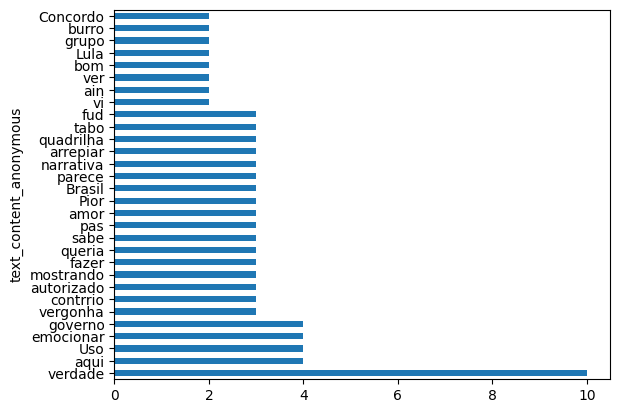

In [48]:
unigramas.value_counts().iloc[:30].plot.barh()

<Axes: ylabel='text_content_anonymous'>

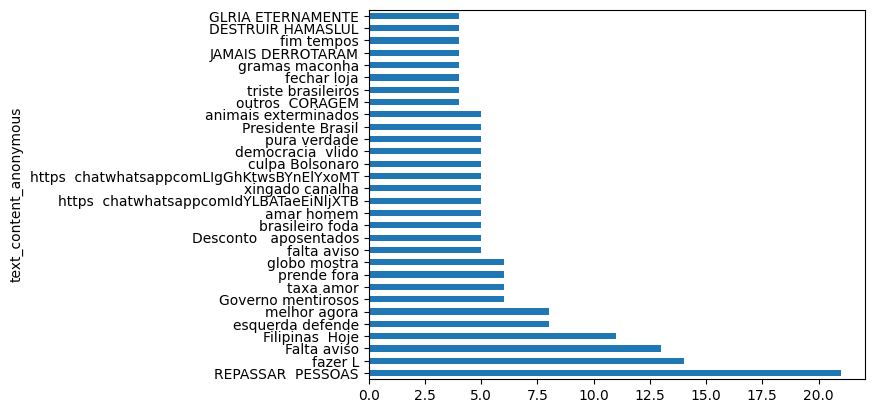

In [49]:
bigramas = frases_corrigidas[frases_corrigidas.apply(lambda x: len(x.split())) == 2 ]
bigramas.value_counts().iloc[:30].plot.barh()

<Axes: ylabel='text_content_anonymous'>

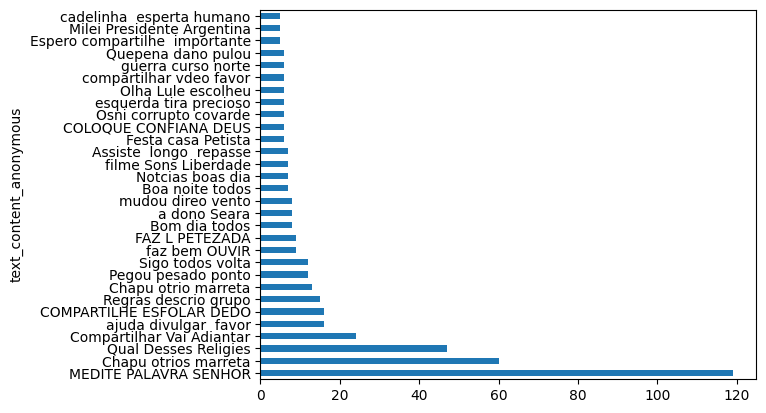

In [50]:
trigramas = frases_corrigidas[frases_corrigidas.apply(lambda x: len(x.split())) == 3 ]
trigramas.value_counts().iloc[:30].plot.barh()

## 21. As 30 mensagens mais positivas (distintas);

In [51]:
'''
df.groupby("text_content_anonymous")["score_sentiment"].mean().sort_values(ascending = False).iloc[:30]
'''
# Textos gigantes, mas ta aí o código

'\ndf.groupby("text_content_anonymous")["score_sentiment"].mean().sort_values(ascending = False).iloc[:30]\n'

## 22. As 30 mensagens mais negativas (distintas);

In [52]:
'''
df.groupby("text_content_anonymous")["score_sentiment"].mean().sort_values(ascending = True).iloc[:30]
'''
# Textos gigantes, mas ta aí o código

'\ndf.groupby("text_content_anonymous")["score_sentiment"].mean().sort_values(ascending = True).iloc[:30]\n'

## 23. O usuário mais otimista;

In [53]:
df.columns

Index(['id', 'date_message', 'id_member_anonymous', 'ddi', 'ddd', 'country',
       'country_iso3', 'state', 'id_group_anonymous', 'media', 'media_type',
       'media_url', 'has_media', 'has_media_url', 'trava_zap',
       'text_content_anonymous', 'latitude', 'longitude', 'date_system',
       'score_sentiment', 'score_misinformation', 'messenger', 'media_name',
       'media_md5'],
      dtype='object')

In [54]:
df_23 = df.groupby("id_member_anonymous")["score_sentiment"].mean().sort_values(ascending = False).reset_index().iloc[0]
df_23

id_member_anonymous    ef7d805090536f20c0d6c4edaf6272ff
score_sentiment                                  0.9978
Name: 0, dtype: object

## 24. O usuário mais pessimista;

In [55]:
df_23 = df.groupby("id_member_anonymous")["score_sentiment"].mean().sort_values(ascending = True).reset_index().iloc[0]
df_23

id_member_anonymous    2afa4ac55a1fc5fb4bfea47b2b01e1ee
score_sentiment                                 -0.9993
Name: 0, dtype: object

## 25. As 30 maiores mensagens;

In [56]:
df_25 = df["text_content_anonymous"].sort_values(key = lambda x: x.apply(lambda y: len(y)), ascending = False )
df_25[~df_25.duplicated()].iloc[:30]

186543    🇧🇷ALMENARA|MG|BR|DIREITA CONSERVADORA|MANIFEST...
193341    🇧🇷ALMENARA|MG|BR|DIREITA CONSERVADORA|MANIFEST...
188240    ֺ✬✬✬✞ɩ᪶ᷞϵ̊ₖͮɪⷷ❖ᴆⷦₖᷝ₈ᷡ₉ᷚ✞✬✬✬\n🥶ًࣩࣩࣩࣩࣩࣩࣩࣩࣩࣩࣩ֮֮֮....
357932    INELEGÍVEL INELEGÍVEL INELEGÍVEL INELEGÍVEL IN...
286885    *5 dicas para fortalecer unhas fracas e quebra...
405668    📰 *JRMUNEWS, Ano 5, Nº 1735* 🗞\n📌 *De Pariquer...
336958    📰 *JRMUNEWS, Ano 5, Nº 1719* 🗞\n📌 *De Pariquer...
28453     📰 *JRMUNEWS, Ano 5, Nº 1668* 🗞\n📌 *De Pariquer...
298337    📰 *JRMUNEWS, Ano 5, Nº 1713* 🗞\n📌 *De Pariquer...
41379     Inicial\n\nSobre\n\nDR. DERMEVAL REIS JUNIOR\n...
281365    📰 *JRMUNEWS, Ano 5, Nº 1707* 🗞\n📌 *De Pariquer...
187680    📰 *JRMUNEWS, Ano 5, Nº 1691* 🗞\n📌 *De Pariquer...
245601    _CADERNO DE GEOGRAFIA DA REVISTA COLOMBIANA DE...
108824    📰 *JRMUNEWS, Ano 5, Nº 1680* 🗞\n📌 *De Pariquer...
122241    *VOCÊ 🫵 TEM QUE LER ESSE TEXTO, PARA COMPREEND...
181597       \nASSINE\n\nIdeias\nEsquerdismo\n“Complexo ...
113279    📰 *JRMUNEWS, Ano 5, Nº 1681* 🗞

## 26. As 30 menores mensagens;

In [57]:
df_26 = df["text_content_anonymous"].sort_values(key = lambda x: x.apply(lambda y: len(y)), ascending = True )
df_26[~df_26.duplicated()].iloc[:30]

108285         😁 e Faz o L
393579         A L E R T A
223308         Faz o L 👈 👆
81628          P Q P . . .
213281        A o Amor 💘 💘
42840        Faz o L 👈 👆🤭😂
2255         Bom dia 🌺 🌹 🌺
213792      O q robou d vc
48837       Tem o meu tb 😍
351340      Td o q eu faço
227602      De 17 pra 21 %
338934     É só fazer um L
88291      L L L L L 😂😂😂😂😂
376256     Há uns 2 dias 👆
13860      Ou tá pau a pau
265892     Hoje é com " j"
201837     E vão toma no 🆒
395857     Ipê fez o L tbm
3856       Em 8 meses em 🙈
210934     E o 04 é viado?
4129       Ó o grosso aí 👆
309096     O que tem a ver
159774     Sei o que é URV
280839     O que ele n tem
339701     Se joga na BR 😅
161589     O crt é n subir
156986    Só quem fez o L.
322190    O fim é triste 😢
188161    Q porra é isso ?
239199    Só sei q fico  🤬
Name: text_content_anonymous, dtype: object

## 27. O dia em que foi publicado a maior quantidade de mensagens;

In [65]:
df_27 = df.copy()
df_27["date_message"] = df_27["date_message"].dt.date
df_27.groupby("date_message")["text_content_anonymous"].count().sort_values(ascending = False).reset_index().iloc[0]

date_message              2023-11-15
text_content_anonymous          4585
Name: 0, dtype: object

## 28. As mensagens que possuem as palavras “INTERVENÇÃO” e “MILITAR”;

In [68]:
df[ (df["text_content_anonymous"].str.contains("INTERVENÇÃO")) & (df["text_content_anonymous"].str.contains("MILITAR")) ]["text_content_anonymous"]

11893     *CUIDADO... CUIDADO... CUIDADO...🆘🆘🆘🆘🆘🆘🆘🆘🆘🆘🆘🚨🚨...
70722     O POVO VAI FERRAR O BRASIL!!! NÃO É IMPEACHMEN...
124806    🚨 INTERVENÇÃO POLICIAL MILITAR COM RESULTADO M...
175106    Como CORRUPTOS como este FLÁVIO DINO... XANDÃO...
175350    Como CORRUPTOS como este FLÁVIO DINO... XANDÃO...
219130    *A CNN INTERNACIONAL DISSE QUE A CHINA VAI FAZ...
239091    Todo povo tem o governo que merece, o povo bra...
298583    *URGENTE! A PARTIR DE AGORA SÓ HAVERÁ UMA VERD...
315211    ATENÇÃO PATRIOTA \n\n\nTudo arquitetado pela e...
315214    ATENÇÃO PATRIOTA \n\n\nTudo arquitetado pela e...
332030    *- URGENTE -*\n*LULA ANUNCIA INTERVENÇÃO COM M...
332031    *- URGENTE -*\n*LULA ANUNCIA INTERVENÇÃO COM M...
332032    *- URGENTE -*\n*LULA ANUNCIA INTERVENÇÃO COM M...
332033    *- URGENTE -*\n*LULA ANUNCIA INTERVENÇÃO COM M...
332034    *- URGENTE -*\n*LULA ANUNCIA INTERVENÇÃO COM M...
332650    *- URGENTE -*\n*LULA ANUNCIA INTERVENÇÃO COM M...
332656    *- URGENTE -*\n*LULA ANUNCIA I

## 29. Quantidade de mensagens por dia e hora;

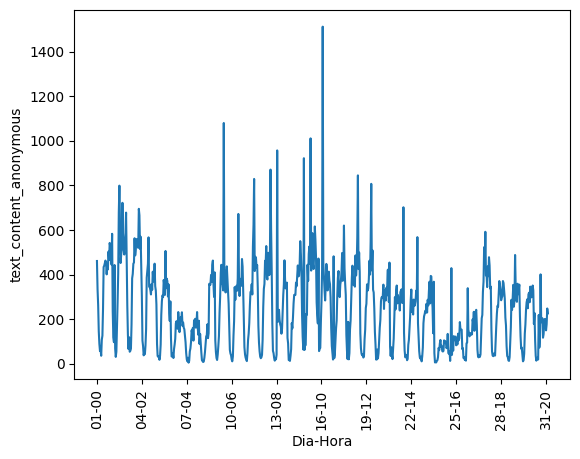

In [82]:
df_29 = df.copy()
df_29["Dia-Hora"] = df['date_message'].dt.strftime('%d-%H')
df_29 = df_29.groupby("Dia-Hora")["text_content_anonymous"].count().reset_index()
sns.lineplot(df_29, x = "Dia-Hora", y = "text_content_anonymous")
num_labels = 10
interval = len(df_29) // num_labels
ticks = np.arange(0, len(df_29), interval)
plt.xticks(ticks, df_29['Dia-Hora'].iloc[ticks], rotation=90)
plt.show()

## 30. Quantidade de mensagens por hora;

In [83]:
df.columns

Index(['id', 'date_message', 'id_member_anonymous', 'ddi', 'ddd', 'country',
       'country_iso3', 'state', 'id_group_anonymous', 'media', 'media_type',
       'media_url', 'has_media', 'has_media_url', 'trava_zap',
       'text_content_anonymous', 'latitude', 'longitude', 'date_system',
       'score_sentiment', 'score_misinformation', 'messenger', 'media_name',
       'media_md5'],
      dtype='object')

<Axes: xlabel='Hora', ylabel='text_content_anonymous'>

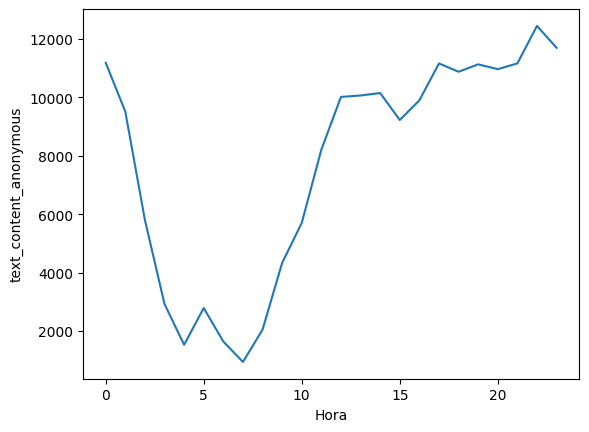

In [84]:
df_30 = df.copy()
df_30["Hora"] = df['date_message'].dt.hour
df_30 = df_30.groupby("Hora")["text_content_anonymous"].count().reset_index()
sns.lineplot(df_30, x = "Hora", y = "text_content_anonymous")


## 31. A nuvem de palavras referente às mensagens de texto (após a remoção de sstop words);

In [85]:
df.columns


Index(['id', 'date_message', 'id_member_anonymous', 'ddi', 'ddd', 'country',
       'country_iso3', 'state', 'id_group_anonymous', 'media', 'media_type',
       'media_url', 'has_media', 'has_media_url', 'trava_zap',
       'text_content_anonymous', 'latitude', 'longitude', 'date_system',
       'score_sentiment', 'score_misinformation', 'messenger', 'media_name',
       'media_md5'],
      dtype='object')

(185455, 24)


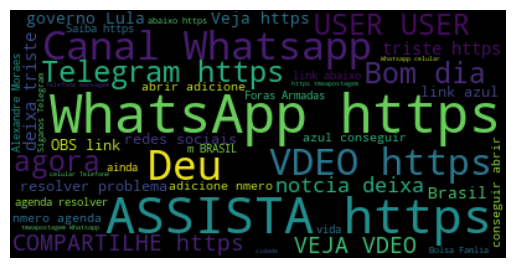

In [92]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


print(df.shape)
texto_final = corrigir_string(" ".join(df["text_content_anonymous"].iloc[:50000]))

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(texto_final)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 32. A rede interativa das palavras referente às mensagens de texto (após a rremoção de stop words);

## 33. Proporção de mensagens com e sem URL;

<Axes: >

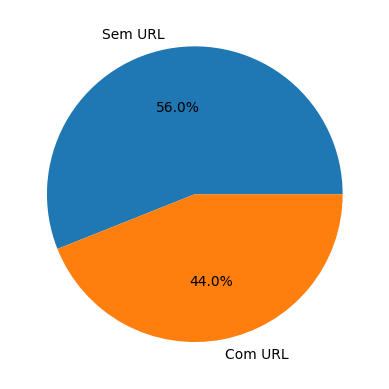

In [98]:
df["has_media_url"].value_counts().set_axis(["Sem URL", "Com URL"]).plot.pie(ylabel = "", autopct='%1.1f%%')

## 34. Proporção de desinformação;

In [99]:
df.columns

Index(['id', 'date_message', 'id_member_anonymous', 'ddi', 'ddd', 'country',
       'country_iso3', 'state', 'id_group_anonymous', 'media', 'media_type',
       'media_url', 'has_media', 'has_media_url', 'trava_zap',
       'text_content_anonymous', 'latitude', 'longitude', 'date_system',
       'score_sentiment', 'score_misinformation', 'messenger', 'media_name',
       'media_md5'],
      dtype='object')

<Axes: >

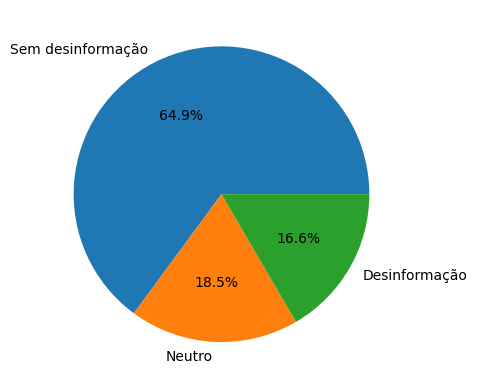

In [112]:
def label_desinformacao(x):
    if np.isnan(x): return np.nan
    elif x < 0.33: return "Sem desinformação"
    elif x < 0.67: return "Neutro"
    return "Desinformação"

df["score_misinformation"].apply(label_desinformacao).value_counts().plot.pie(ylabel = "", autopct='%1.1f%%')

## 35. Proporção de mensagens contendo mídia e desinformação;

<Axes: >

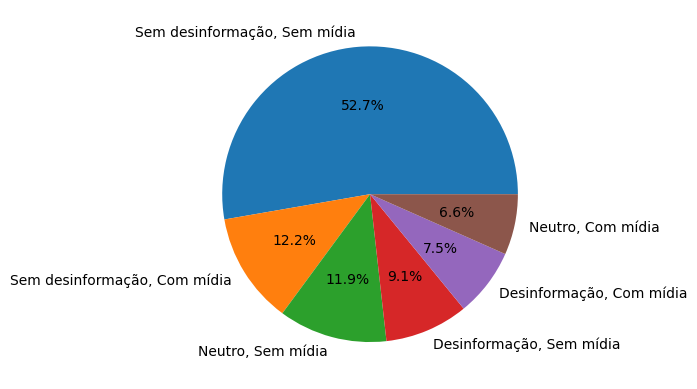

In [118]:
def labels_q35(x):
    label_1 = x["score_misinformation"].apply(label_desinformacao)
    label_2 = x["has_media"].apply(lambda x: "Com mídia" if x == True else "Sem mídia")

    remover = label_1.isna() | label_2.isna()
    label_1 = label_1[~remover]
    label_2 = label_2[~remover]

    return label_1 + ", " + label_2

labels_q35(df).value_counts().plot.pie(ylabel = "", autopct='%1.1f%%')

## 36. Distribuição de mensagens por score de desinformação;

<Axes: >

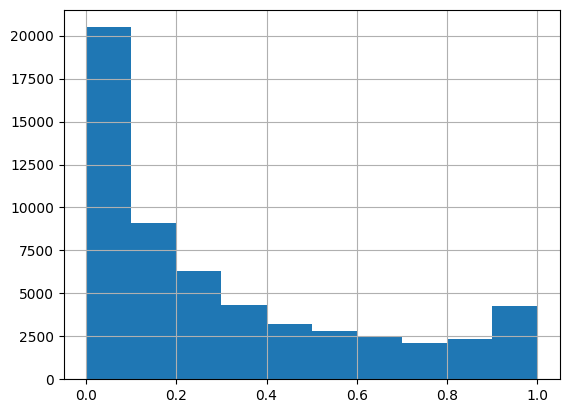

In [120]:
df["score_misinformation"].hist()

## 37. Proporção de sentimentos;

<Axes: >

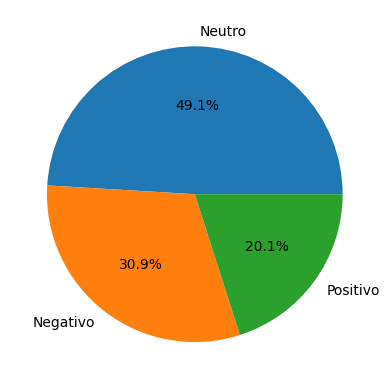

In [122]:
def label_sentimento(x):
    if np.isnan(x): return np.nan
    elif x < -0.33: return "Negativo"
    elif x < 0.34: return "Neutro"
    return "Positivo"

df["score_sentiment"].apply(label_sentimento).value_counts().plot.pie(ylabel = "", autopct='%1.1f%%')

## 38. Distribuição de mensagens por score de sentimentos;

<Axes: >

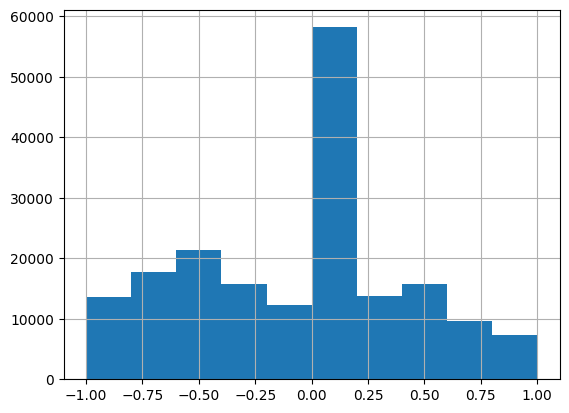

In [123]:
df["score_sentiment"].hist()